In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pandas as pd

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

plt.rcParams['axes.grid'] = False

In [4]:
dataset_path = '/opt/ml/segmentation/input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

with open(anns_file_path, "r") as f:
    dataset = json.loads(f.read())

dataset.keys()

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

In [8]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']

nr_cats = len(categories)
nr_anns = len(anns)
nr_imgs = len(imgs)

print(f'number of categories:{nr_cats}')
print(f'number of annotations:{nr_anns}')
print(f'number of images:{nr_imgs}')

number of categories:10
number of annotations:26240
number of images:3272


In [10]:
cat_names = []
for category in categories:
    cat_names.append(category['name'])
print(cat_names)

['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']


In [15]:
cat_histogram = np.zeros(nr_cats, dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1]+=1

df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)
df

,Categories,Number of annotations
1,Paper,9311
7,Plastic bag,7643
5,Plastic,3090
0,General trash,2782
6,Styrofoam,1343
2,Paper pack,659
4,Glass,610
3,Metal,562
9,Clothing,177
8,Battery,63


In [22]:
df['Paper'].

Categories               Paper
Number of annotations     9311
Name: 1, dtype: object

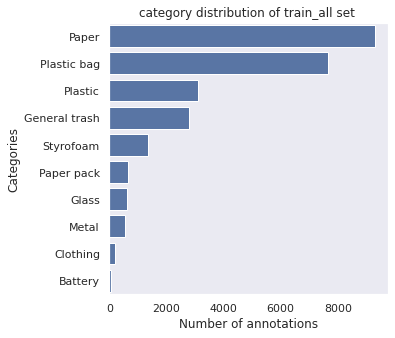

In [16]:
f, ax = plt.subplots(figsize = (5,5))
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [17]:
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [18]:
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,General trash,2782.0
2,Paper,9311.0
3,Paper pack,659.0
4,Metal,562.0
5,Glass,610.0
6,Plastic,3090.0
7,Styrofoam,1343.0
8,Plastic bag,7643.0
9,Battery,63.0


In [19]:
coco = COCO(anns_file_path)
img_id = coco.getImgIds(imgIds=5)
img_info = coco.loadImgs(img_id)[0]

loading annotations into memory...
Done (t=5.29s)
creating index...
index created!


In [22]:
img_id = coco.getImgIds(imgIds=[5,6])
img_info = coco.loadImgs(img_id)
img_info

[{'license': 0,
  'url': None,
  'file_name': 'batch_01_vt/0009.jpg',
  'height': 512,
  'width': 512,
  'date_captured': None,
  'id': 5},
 {'license': 0,
  'url': None,
  'file_name': 'batch_01_vt/0010.jpg',
  'height': 512,
  'width': 512,
  'date_captured': None,
  'id': 6}]

In [26]:
from collections import Counter

num_anns_per_img = []
for img in imgs:
    num_anns = len(coco.getAnnIds(imgIds = img['id']))
    num_anns_per_img.append(num_anns)
# print(num_anns_per_img)
counts = Counter(num_anns_per_img)
print(counts)

Counter({1: 834, 2: 353, 3: 244, 4: 198, 5: 152, 6: 146, 7: 141, 8: 110, 9: 96, 12: 91, 10: 84, 11: 83, 13: 68, 14: 64, 15: 63, 16: 61, 17: 52, 19: 49, 20: 40, 18: 36, 23: 30, 22: 29, 25: 26, 24: 26, 26: 25, 28: 21, 21: 19, 31: 16, 27: 12, 29: 12, 33: 10, 37: 9, 34: 9, 32: 8, 30: 8, 39: 6, 38: 4, 45: 3, 56: 3, 46: 3, 44: 3, 50: 2, 42: 2, 43: 2, 36: 2, 51: 2, 58: 2, 40: 2, 47: 1, 55: 1, 35: 1, 59: 1, 53: 1, 57: 1, 70: 1, 64: 1, 41: 1, 48: 1, 0: 1})


In [35]:
df2 = pd.DataFrame(list(counts.items()), columns=['objects per img', 'Num'])
df2 = df2.sort_values('objects per img', 0, True)
df2.head()

,objects per img,Num
58,0,1
2,1,834
3,2,353
9,3,244
12,4,198


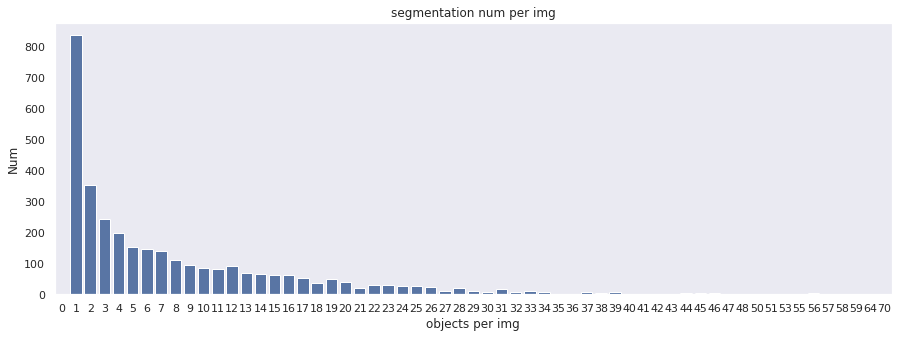

In [40]:
f, ax = plt.subplots(figsize = (15,5))
plt.title("segmentation num per img")
plot_1 = sns.barplot(x="objects per img", y="Num", data=df2, label="Total", color="b")

In [41]:
areas = []
for ann in anns:
    areas.append(ann['area'])
max_area = max(areas)
min_area = min(areas)

print(max_area, min_area)

261109.0 1.0


In [42]:
area_distribution = {'0~100':0,
                    '101~1000':0,
                    '1001~10000':0,
                    '10001~100000':0,
                    '100001~':0}
for area in areas:
    if area<=100:
        area_distribution['0~100']+=1
    elif area<=1000:
        area_distribution['101~1000']+=1
    elif area<=10000:
        area_distribution['1001~10000']+=1
    elif area<=100000:
        area_distribution['10001~100000']+=1
    else:
        area_distribution['100001~']+=1
print(area_distribution)

{'0~100': 528, '101~1000': 7418, '1001~10000': 10996, '10001~100000': 7169, '100001~': 129}


In [48]:
df3 = pd.DataFrame(list(area_distribution.items()), columns=['area', 'Num'])

df3

,area,Num
0,0~100,528
1,101~1000,7418
2,1001~10000,10996
3,10001~100000,7169
4,100001~,129


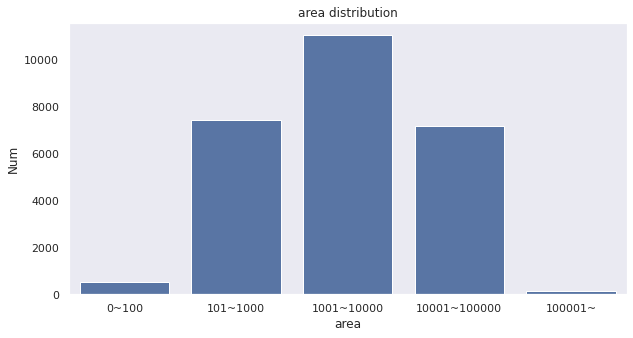

In [49]:
f, ax = plt.subplots(figsize = (10,5))
plt.title("area distribution")
plot_1 = sns.barplot(x="area", y="Num", data=df3, label="Total", color="b")

In [31]:
classes = []
for img in imgs:
    ann_ids = coco.getAnnIds(img['id'])
    ann_lst = coco.loadAnns(ann_ids)
    min_cat = int(1e9)
    for ann in ann_lst:
        category = ann['category_id']
        if cat_histogram[category-1] < min_cat:
            min_cat = cat_histogram[category-1]
            img_class = category-1
    if min_cat == int(1e9):
        img_class=-1
    classes.append(img_class)
len(classes)
max(classes)
print(Counter(classes))

Counter({0: 782, 7: 484, 6: 409, 5: 357, 2: 345, 3: 310, 1: 283, 4: 170, 9: 112, 8: 19, -1: 1})


In [70]:
from sklearn.model_selection import StratifiedKFold
stratifiedkfold = StratifiedKFold(n_splits=5,random_state=1234,shuffle=True)

X=np.array([[img['id']] for img in imgs])
classes = np.array(classes)

for i, idx in enumerate(stratifiedkfold.split(X,classes)):
    train_index, validate_index = idx
    
    train_json = f'kfold_{i}_train.json'
    val_json = f'kfold_{i}_val.json'
    
    
    # print("train index:", train_index, "validate index:", validate_index)
    X_train = X[train_index]
    X_train = [x[0] for x in X_train]
    class_train = classes[train_index]
    
    X_valid = X[validate_index]
    X_valid = [x[0] for x in X_valid]
    class_valid = classes[validate_index]
    
    train_images_id = coco.getImgIds(X_train)
    train_images = coco.loadImgs(train_images_id)
    
    train_anns_id = coco.getAnnIds(train_images_id)
    train_anns = coco.loadAnns(train_anns_id)
    
    val_images_id = coco.getImgIds(X_valid)
    val_images = coco.loadImgs(val_images_id)
    
    val_anns_id = coco.getAnnIds(val_images_id)
    val_anns = coco.loadAnns(val_anns_id)
    
    for i, train_image in enumerate(train_images):
        origin_id = train_image['id']
        train_image['id'] = i
        for train_ann in train_anns:
            if train_ann['image_id'] == origin_id:
                train_ann['image_id'] = i
    
    for i, val_image in enumerate(val_images):
        origin_id = val_image['id']
        val_image['id'] = i
        for val_ann in val_anns:
            if val_ann['image_id'] == origin_id:
                val_ann['image_id'] = i
    # print(train_images)

    # print('========')
    # print(train_anns[0])
    # print()
    # print(class_train)
    # print(i)
    train_data = {
        "info": dataset['info'],
        "licenses": dataset['licenses'],
        "images": train_images,
        "categories":dataset['categories'],
        "annotations": train_anns,
    }
    val_data = {
        "info": dataset['info'],
        "licenses": dataset['licenses'],
        "images": val_images,
        "categories":dataset['categories'],
        "annotations": val_anns,
    }
    
    # print(val_data['annotations'][0])
    
    print(f'write {train_json}')
    with open(dataset_path + '/' + train_json, 'w') as train_writer:
        json.dump(train_data, train_writer)
    
    print(f'write {val_json}')
    with open(dataset_path + '/' + val_json, 'w') as val_writer:
        json.dump(val_data, val_writer)

write kfold_0_train.json
write kfold_0_val.json
write kfold_1_train.json
write kfold_1_val.json
write kfold_2_train.json
write kfold_2_val.json
write kfold_3_train.json
write kfold_3_val.json
write kfold_4_train.json
write kfold_4_val.json
